![title](./img/Header.jpg)

<h1><center>Covid-19 Tweet Clustering </center></h1>



## Indíce
* [Introducción: Presentación del proyecto](#sarrera)
* [Datos](#datuak)
* [Data pre-processing](#dpr)
    * [Visualización de los datos](#ikuskapena)
    * [Adaptación de los datos](#moldaketa)
* [Exploratory Data Analysis](#exploratory)
* [Konklusioa](#conclusion)

# Introducción: Presentación del proyecto <a name="sarrera"></a>

Este 

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msg
import string
import re
import nltk
from spellchecker import SpellChecker
from nltk.corpus import stopwords
from sklearn import preprocessing
from collections import Counter
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from imageio import imread
import pickle


ModuleNotFoundError: No module named 'wordcloud'

<hr>

# Datos <a name="datuak"></a>

In [24]:
df = pd.read_csv("./Corona_NLP_train.csv", engine='python')
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know it��s getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [25]:
df.drop(columns={'UserName','ScreenName','Location','TweetAt'},axis=1,inplace=True)
df

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...
41152,Airline pilots offering to stock supermarket s...,Neutral
41153,Response to complaint not provided citing COVI...,Extremely Negative
41154,You know it��s getting tough when @KameronWild...,Positive
41155,Is it wrong that the smell of hand sanitizer i...,Neutral


<hr>

# Data pre-processing <a name="dpr"></a>

## Visualización de los datos <a name="ikuskapena"></a>

Lehenegoz, datu falta aztertuko dugu, badaezpada ere.

In [26]:
missing_data = df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  41157 non-null  object
 1   Sentiment      41157 non-null  object
dtypes: object(2)
memory usage: 643.2+ KB


<AxesSubplot:>

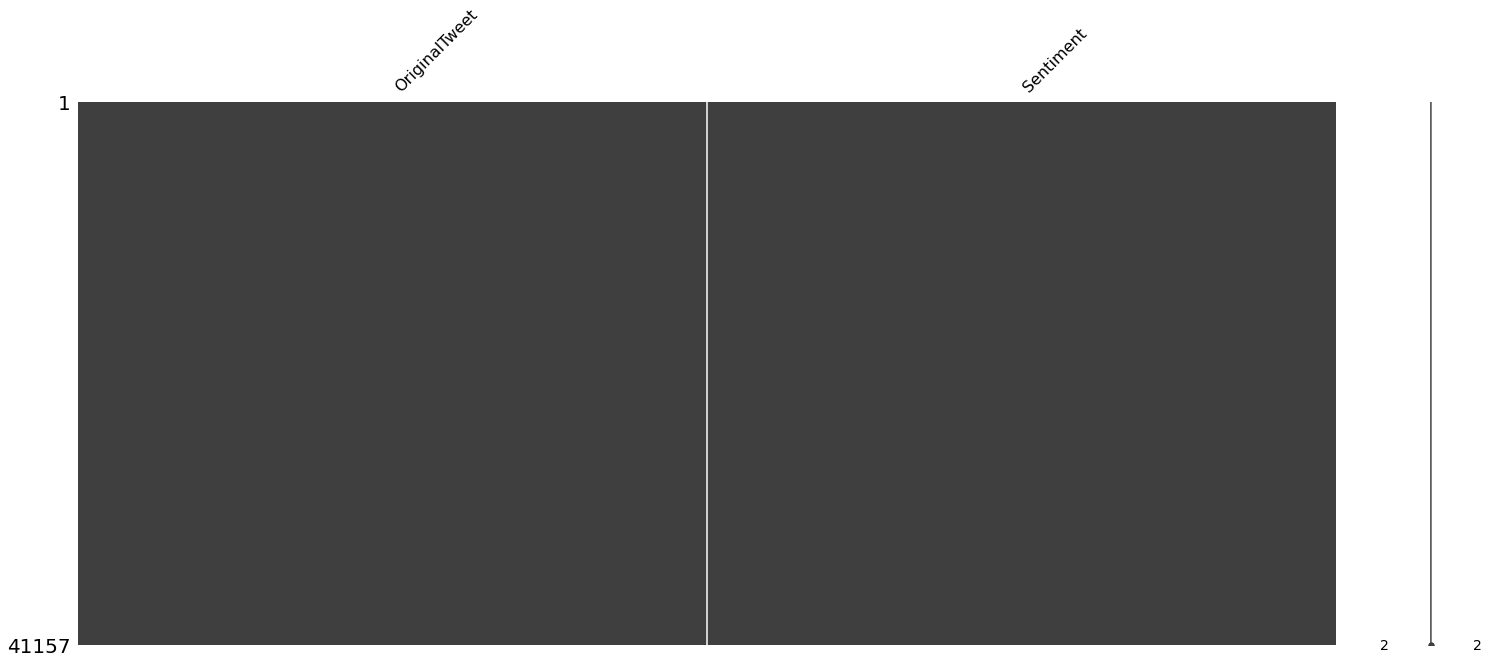

In [27]:
msg.matrix(df)

Como se puede apreciar, no encontramos ninguna entidad con un valor NaN

## Adaptación de los datos<a name="moldaketa"></a>
### Hemos dividido el preprocessing en diez pasos diferentes:
1. Borrar las URL
2. Transformar los emoticonos
3. Transformar los emojis
4. Transformar las abreviaciones
5. Pasar todo a minúsculas
6. Quitar los stopwords
7. Quitar las marcas de puntuacion
8. Corregir palabras
9. Lemmanization
10. Corregir palabras

### 1.Borrar las URL
En los tweets podemos encontrar URL-s las cuales no no son de utilidad. Es por ello que vamos a eliminarlas.

 <img src="./media/linkCase.png" alt="drawing" width="600"/>

In [28]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)
df["OriginalTweet"] = df["OriginalTweet"].apply(lambda text: remove_urls(text))

### 2. Transformar los emoticonos
Debajo tenemos comprimida toda la lista de emoticonos: https://unicode.org/emoji/charts/full-emoji-list.html , no nos interesa eliminarnos, ya que pueden incluir información del contexto.


 <img src="./media/emotiCase.png" alt="drawing" width="600"/>

In [ ]:
def convert_emojis(text):
    for emot in UNICODE_EMO:
        text = re.sub(
            r'('+emot+')', "_".join(UNICODE_EMO[emot].replace(",", "").replace(":", "").split()), text)
    return text

In [ ]:
df["OriginalTweet"] = df["OriginalTweet"].apply(
    lambda text: convert_emojis(text))

### 3. Transformar los emojis
Lehen egin dugun moduan, orain emotikonoekin:  https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py

 <img src="./media/emojiCase.png" alt="drawing" width="600"/>

In [ ]:
def convert_emoticons(text):
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', "_".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

In [ ]:
df["OriginalTweet"] = df["OriginalTweet"].apply(lambda text: convert_emoticons(text))

### 4. Transformar las abreviaciones
Es muy común que en redes sociales, sobretodo en la habla inglesa, se utilicen abreviacionen. Estas pueden ofrecernos informacion interesante, es por ello que vmaos a transformarlas a frases hechas.
BRB = Be right back
CYA = See you later

In [29]:
chat_words_str = """
AFAIK=As Far As I Know
AFK=Away From Keyboard
ASAP=As Soon As Possible
ATK=At The Keyboard
ATM=At The Moment
A3=Anytime, Anywhere, Anyplace
BAK=Back At Keyboard
BBL=Be Back Later
BBS=Be Back Soon
BFN=Bye For Now
B4N=Bye For Now
BRB=Be Right Back
BRT=Be Right There
BTW=By The Way
B4=Before
B4N=Bye For Now
CU=See You
CUL8R=See You Later
CYA=See You
FAQ=Frequently Asked Questions
FC=Fingers Crossed
FWIW=For What It's Worth
FYI=For Your Information
GAL=Get A Life
GG=Good Game
GN=Good Night
GMTA=Great Minds Think Alike
GR8=Great!
G9=Genius
IC=I See
ICQ=I Seek you (also a chat program)
ILU=ILU: I Love You
IMHO=In My Honest/Humble Opinion
IMO=In My Opinion
IOW=In Other Words
IRL=In Real Life
KISS=Keep It Simple, Stupid
LDR=Long Distance Relationship
LMAO=Laugh My A.. Off
LOL=Laughing Out Loud
LTNS=Long Time No See
L8R=Later
MTE=My Thoughts Exactly
M8=Mate
NRN=No Reply Necessary
OIC=Oh I See
PITA=Pain In The A..
PRT=Party
PRW=Parents Are Watching
ROFL=Rolling On The Floor Laughing
ROFLOL=Rolling On The Floor Laughing Out Loud
ROTFLMAO=Rolling On The Floor Laughing My A.. Off
SK8=Skate
STATS=Your sex and age
ASL=Age, Sex, Location
THX=Thank You
TTFN=Ta-Ta For Now!
TTYL=Talk To You Later
U=You
U2=You Too
U4E=Yours For Ever
WB=Welcome Back
WTF=What The F...
WTG=Way To Go!
WUF=Where Are You From?
W8=Wait...
7K=Sick:-D Laugher
"""

In [30]:
chat_words_map_dict = {}
chat_words_list = []
for line in chat_words_str.split("\n"):
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[1]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded
chat_words_list = set(chat_words_list)

def chat_words_conversion(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

### 5. Pasar todo a minusculas

Para que sea mas sencillo el procesamiento del texto, vamos a trasnformar todas las frases a minusculas.

In [31]:
df["OriginalTweet"] = df["OriginalTweet"].str.lower()

### 6. Quitar los stopwords

Las conocidas como "palabras vacias" son aquellas que no nos van a aportar ninguna información, es por ello que vamos a eliminaras.


In [34]:
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [35]:
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.add('u')
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in set(stopwords.words('english'))])

df["OriginalTweet"] = df["OriginalTweet"].apply(lambda text:remove_stopwords(text))

### 7. Quitar las marcas de puntuacion

Puntuazio markak ez zaizkigu interesatzen, hori dela eta, kenduko ditugu

In [36]:
print(df["OriginalTweet"][12])

#horningsea caring community. let��s look less capable village ensure stay healthy. bringing shopping doors, help online shopping self isolation symptoms exposed somebody has.


In [37]:
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    PUNCT_TO_REMOVE = string.punctuation
    PUNCT_TO_REMOVE += 'â’'
    spaces = ''
    for i in range(len(PUNCT_TO_REMOVE)):
        spaces += ' '
    return text.translate(str.maketrans(PUNCT_TO_REMOVE, spaces))
df["OriginalTweet"] = df["OriginalTweet"].apply(lambda text: remove_punctuation(text))

In [38]:
print(df["OriginalTweet"][12])

 horningsea caring community  let��s look less capable village ensure stay healthy  bringing shopping doors  help online shopping self isolation symptoms exposed somebody has 


### 8. Corregir las palabras

In [39]:
df['OriginalTweet'] = df['OriginalTweet'].map(lambda x: re.sub('[^A-Za-z ]+', '', x))

In [40]:
print(df["OriginalTweet"][12])

 horningsea caring community  lets look less capable village ensure stay healthy  bringing shopping doors  help online shopping self isolation symptoms exposed somebody has 




Puede ocurrir que algunas palabras esten mal escritas, es por eso que las vamos a corregir


In [41]:
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [42]:
df["OriginalTweet"] = df["OriginalTweet"].apply(lambda text: correct_spellings(text))

KeyboardInterrupt: 

### 9. Lemmanization

En este proceso, lemmanizamos las palabras, lo cual trata de eliminar las posibles conjugaciones. Mas información en el siguiente link: https://en.wikipedia.org/wiki/Lemmatisation

In [23]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df["OriginalTweet"] = df["OriginalTweet"].apply(lambda text: lemmatize_words(text))

### 10. Corregir palabras

Es posible que despues de todo este proceso, algunas palabras se hayan "corrompido", es por eso que vamos a volver a corregirlas.

In [25]:
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [26]:
df["OriginalTweet"] = df["OriginalTweet"].apply(lambda text: correct_spellings(text))

In [27]:
df.to_csv("../csv/data_preprocess.csv", index=False)

<hr>

# Exploratory Data Analisis <a name="exploratory"></a>

Vamos a utilizar esta sección para analizar los datos y ver si podemos extraer algo de información relevante de esta.

### Datos estadisticos
Vamos a analizar los datos estadísticos, para comprobar si podemos extraer alguna información relevante del conjunto de datos.

In [8]:
df = pd.read_csv("./csv/data_preprocess_ok.csv")

Los diferentes valores de la clase y sus frecuencias

<AxesSubplot:>

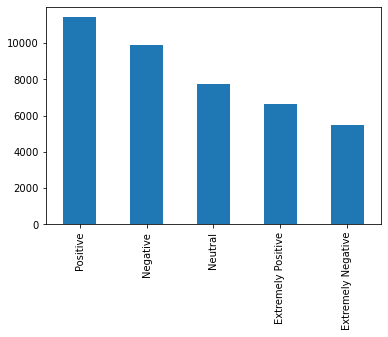

In [9]:
df['Sentiment'].value_counts().plot(kind='bar')

### Palabras mas utillizadas

In [10]:
# df = pd.read_csv("data_preprocess.csv")
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.add('u') #Konponketa 'u' hitza kontuan ez izateko.
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in set(STOPWORDS)])

df["OriginalTweet"] = df["OriginalTweet"].apply(lambda text:remove_stopwords(text))
df['OriginalTweet'] = df['OriginalTweet'].replace({'couid': 'covid'}, regex=True) #Esta transormacion no es valida.
df['OriginalTweet'] = df['OriginalTweet'].replace({'amp': ' '}, regex=True) #& Otro caso de error


NameError: name 'stopwords' is not defined

In [6]:
cnt = Counter()
for text in df["OriginalTweet"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(30)

NameError: name 'Counter' is not defined

### Word cloud

In [6]:
df_negative = df[df["Sentiment"]=="Negative"] #Dataframes dependiendo de la clase
df_neutral = df[df["Sentiment"]=="Neutral"]
df_positive = df[df["Sentiment"]=="Positive"]
df_extremely_positive = df[df["Sentiment"]=="Extremely Positive"]
df_extremely_negative = df[df["Sentiment"]=="Extremely Positive"]

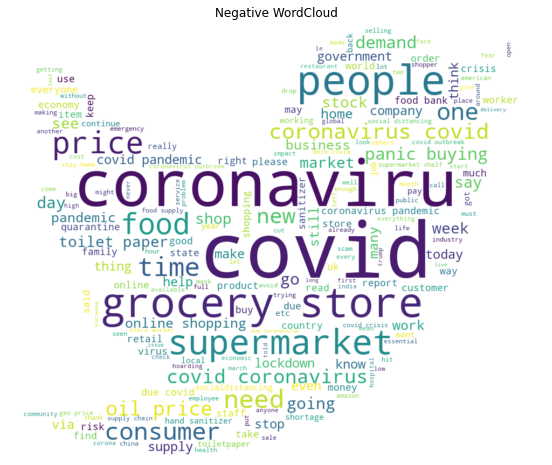

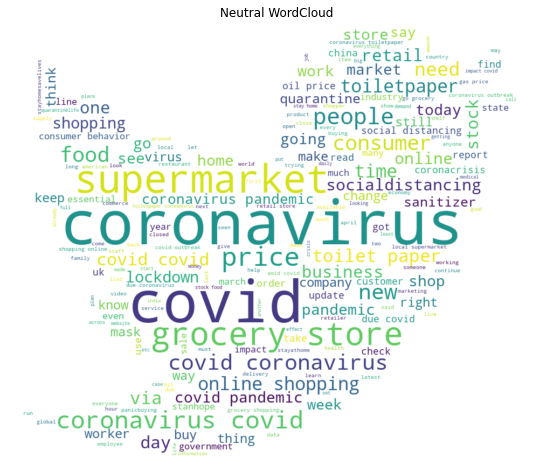

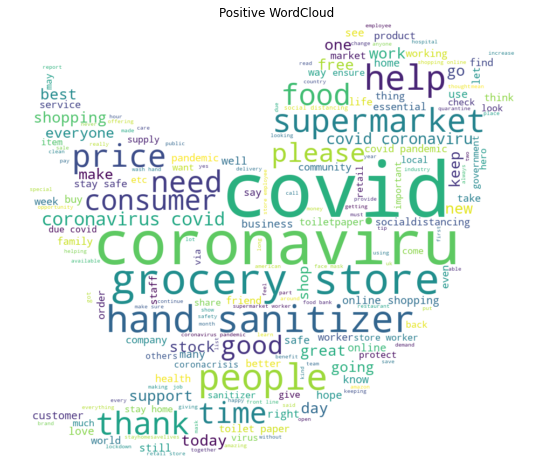

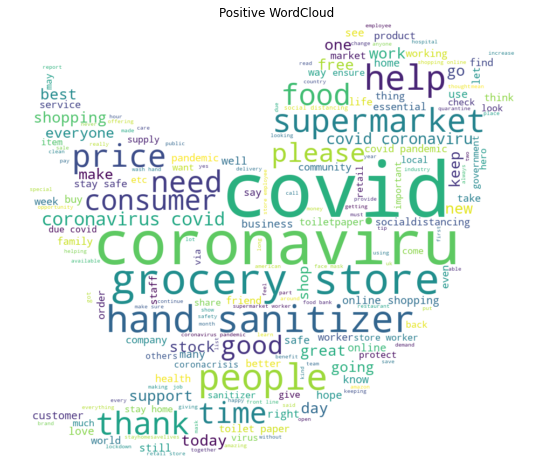

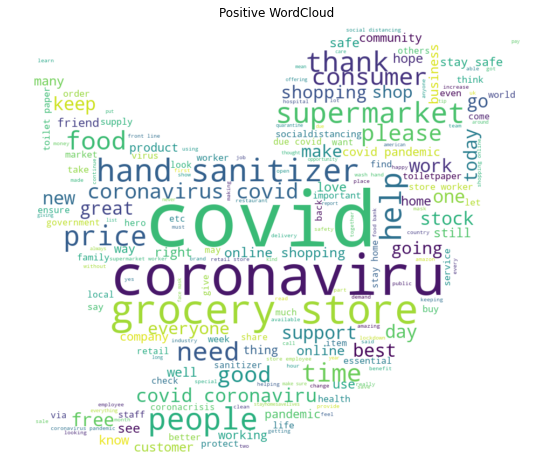

In [11]:
twitter_mask = imread('./media/twitter_mask.png')

wc_negative = WordCloud(background_color='white',width=1800,height=1400,mask=twitter_mask).generate(' '.join(df_negative['OriginalTweet']))
plt.figure(figsize=(10,8))
plt.imshow(wc_negative, interpolation='bilinear')
plt.title("Negative WordCloud")
plt.axis("off")
    
wc_neutral = WordCloud(background_color='white',width=1800,height=1400,mask=twitter_mask).generate(' '.join(df_neutral['OriginalTweet']))
plt.figure(figsize=(10,8))
plt.imshow(wc_neutral, interpolation='bilinear')
plt.title("Neutral WordCloud")
plt.axis("off")

wc_positive = WordCloud(background_color='white',width=1800,height=1400,mask=twitter_mask).generate(' '.join(df_extremely_positive['OriginalTweet']))
plt.figure(figsize=(10,8))
plt.imshow(wc_positive, interpolation='bilinear')
plt.title("Positive WordCloud")
plt.axis("off")
plt.show()


wc_extremely_positive = WordCloud(background_color='white',width=1800,height=1400,mask=twitter_mask).generate(' '.join(df_positive['OriginalTweet']))
plt.figure(figsize=(10,8))
plt.imshow(wc_positive, interpolation='bilinear')
plt.title("Positive WordCloud")
plt.axis("off")
plt.show()


wc_positive = WordCloud(background_color='white',width=1800,height=1400,mask=twitter_mask).generate(' '.join(df_extremely_negative['OriginalTweet']))
plt.figure(figsize=(10,8))
plt.imshow(wc_positive, interpolation='bilinear')
plt.title("Positive WordCloud")
plt.axis("off")
plt.show()


Como puede observarse, aun despues de todo este pre-proceso, algunas palabras siguen siendo muy comunes y no correlacionan con la clase, es por eso que las vamos a eliminar

# Document Embedding

En el proyecto del año pasado, decidimos hacer TF-IDF, este año, hemos decidido ir un paso mas adelante, utilizando Document Embedding.

In [10]:
text_data = np.array(df["OriginalTweet"])
vectorizer = TfidfVectorizer(min_df = 30,stop_words='english') #Garrantzitzua, zein den hitzen agerpen minimoa kontuan hartzeko.
train_bow = vectorizer.fit_transform(text_data)
print("Matrizearen tamaina TF-IDF aplikatu ondoren : ",train_bow.shape) #Modu honetan badakigu zenbat atributu ditugu.

Matrizearen tamaina TF-IDF aplikatu ondoren :  (41157, 2782)


In [11]:
import gensin 


In [ ]:
df_tf.describe()